Interconnect has tasked us with creating a model to forecast their churn of clients. This way they know which clients to push promotions and discounts to. We will use Auc-Roc to check the accuracy of our models.

In [43]:
!pip install lightgbm

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import math
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [45]:
df_contract = pd.read_csv('C:/Users/cmram/Downloads/contract.csv')
df_personal = pd.read_csv('C:/Users/cmram/Downloads/personal.csv')
df_internet = pd.read_csv('C:/Users/cmram/Downloads/internet.csv')
df_phone = pd.read_csv('C:/Users/cmram/Downloads/phone.csv')

In [46]:
dataframes = [df_contract, df_personal, df_internet, df_phone]

df_names = {
    1: "Contract DataFrame",
    2: "Personal DataFrame",
    3: "Internet DataFrame",
    4: "Phone DataFrame"
}

for i, df in enumerate(dataframes, start=1):
    print(f"\n{df_names[i]}:")
    display(df.head())
    display(df.info())


Contract DataFrame:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Personal DataFrame:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Internet DataFrame:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Phone DataFrame:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [47]:
for i, df in enumerate(dataframes, start=1):
    duplicate_count = df.duplicated().sum()
    print(f"DataFrame {i} has {duplicate_count} duplicate rows.")

DataFrame 1 has 0 duplicate rows.
DataFrame 2 has 0 duplicate rows.
DataFrame 3 has 0 duplicate rows.
DataFrame 4 has 0 duplicate rows.


In [48]:
for df in dataframes:
    df.columns = [col.lower() for col in df.columns]

for i, df in enumerate(dataframes, start=1):
    display(df.head())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [49]:
df_contract['paperlessbilling'] = df_contract['paperlessbilling'].replace({'Yes': 1, 'No': 0})

df_contract['enddate'] = df_contract['enddate'].apply(lambda x: 0 if x == "No" else 1)

df_personal['gender'] = df_personal['gender'].replace({'Female': 0, 'Male': 1})

df_personal = df_personal.replace({'Yes': 1, 'No': 0})

df_internet['internetservice'] = df_internet['internetservice'].replace({'DSL': 0, 'Fiber optic': 1})

df_internet = df_internet.replace({'Yes': 1, 'No': 0})
df_phone = df_phone.replace({'Yes': 1, 'No': 0})

In [50]:
print(df_contract['type'].unique())

print(df_contract['paymentmethod'].unique())

['Month-to-month' 'One year' 'Two year']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [51]:
contract_dummies = pd.get_dummies(df_contract['type'], prefix='contract')

payment_dummies = pd.get_dummies(df_contract['paymentmethod'], prefix='payment')

df_contract = pd.concat([df_contract, contract_dummies, payment_dummies], axis=1)

df_contract = df_contract.drop(['type', 'paymentmethod'], axis=1)

In [52]:
print("Contract DataFrame:")
display(df_contract.head())

print("\nPersonal DataFrame:")
display(df_personal.head())

print("\nInternet DataFrame:")
display(df_internet.head())

print("\nPhone DataFrame:")
display(df_phone.head())

Contract DataFrame:


,customerid,begindate,enddate,paperlessbilling,monthlycharges,totalcharges,contract_Month-to-month,contract_One year,contract_Two year,payment_Bank transfer (automatic),payment_Credit card (automatic),payment_Electronic check,payment_Mailed check
0,7590-VHVEG,2020-01-01,0,1,29.85,29.85,True,False,False,False,False,True,False
1,5575-GNVDE,2017-04-01,0,0,56.95,1889.5,False,True,False,False,False,False,True
2,3668-QPYBK,2019-10-01,1,1,53.85,108.15,True,False,False,False,False,False,True
3,7795-CFOCW,2016-05-01,0,0,42.30,1840.75,False,True,False,True,False,False,False
4,9237-HQITU,2019-09-01,1,1,70.70,151.65,True,False,False,False,False,True,False



Personal DataFrame:


,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0



Internet DataFrame:


,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,0,0,1,0,0,0,0
1,5575-GNVDE,0,1,0,1,0,0,0
2,3668-QPYBK,0,1,1,0,0,0,0
3,7795-CFOCW,0,1,0,1,1,0,0
4,9237-HQITU,1,0,0,0,0,0,0



Phone DataFrame:


,customerid,multiplelines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


In [53]:
combined_df = pd.merge(df_contract, df_personal, on='customerid', how='left')

In [54]:
combined_df = pd.merge(combined_df, df_internet, on='customerid', how='left')

In [55]:
combined_df = pd.merge(combined_df, df_phone, on='customerid', how='left')

In [56]:
display(combined_df.head())
display(combined_df.info())
combined_df.shape

,customerid,begindate,enddate,paperlessbilling,monthlycharges,totalcharges,contract_Month-to-month,contract_One year,contract_Two year,payment_Bank transfer (automatic),...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,0,1,29.85,29.85,True,False,False,False,...,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,0,0,56.95,1889.5,False,True,False,False,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,1,1,53.85,108.15,True,False,False,False,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,0,0,42.30,1840.75,False,True,False,True,...,0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,1,1,70.70,151.65,True,False,False,False,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customerid                         7043 non-null   object 
 1   begindate                          7043 non-null   object 
 2   enddate                            7043 non-null   int64  
 3   paperlessbilling                   7043 non-null   int64  
 4   monthlycharges                     7043 non-null   float64
 5   totalcharges                       7043 non-null   object 
 6   contract_Month-to-month            7043 non-null   bool   
 7   contract_One year                  7043 non-null   bool   
 8   contract_Two year                  7043 non-null   bool   
 9   payment_Bank transfer (automatic)  7043 non-null   bool   
 10  payment_Credit card (automatic)    7043 non-null   bool   
 11  payment_Electronic check           7043 non-null   bool 

None

(7043, 25)

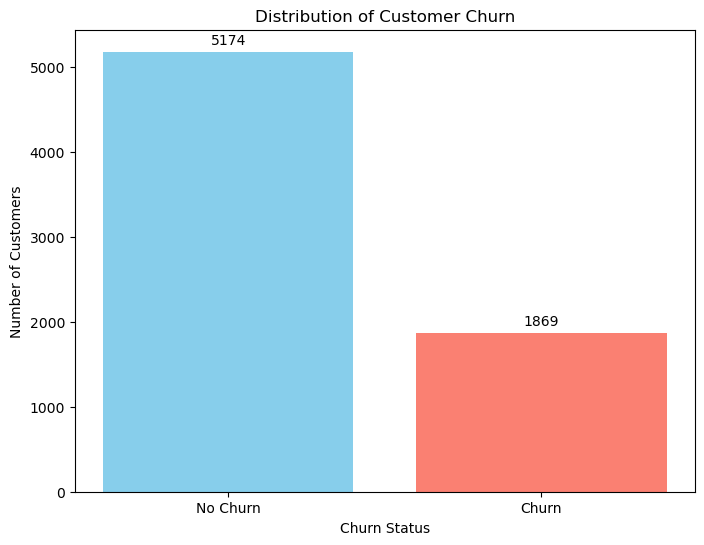

In [57]:
churn_counts = combined_df['enddate'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(churn_counts.index, churn_counts.values, 
               color=['skyblue', 'salmon'])

plt.xticks([0, 1], ['No Churn', 'Churn'])

plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Churn')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom')

plt.show()

In [58]:
combined_df.isna().sum()

customerid                              0
begindate                               0
enddate                                 0
paperlessbilling                        0
monthlycharges                          0
totalcharges                            0
contract_Month-to-month                 0
contract_One year                       0
contract_Two year                       0
payment_Bank transfer (automatic)       0
payment_Credit card (automatic)         0
payment_Electronic check                0
payment_Mailed check                    0
gender                                  0
seniorcitizen                           0
partner                                 0
dependents                              0
internetservice                      1526
onlinesecurity                       1526
onlinebackup                         1526
deviceprotection                     1526
techsupport                          1526
streamingtv                          1526
streamingmovies                   

In [59]:
combined_df = combined_df.fillna(0)

In [60]:
combined_df.isna().sum()

customerid                           0
begindate                            0
enddate                              0
paperlessbilling                     0
monthlycharges                       0
totalcharges                         0
contract_Month-to-month              0
contract_One year                    0
contract_Two year                    0
payment_Bank transfer (automatic)    0
payment_Credit card (automatic)      0
payment_Electronic check             0
payment_Mailed check                 0
gender                               0
seniorcitizen                        0
partner                              0
dependents                           0
internetservice                      0
onlinesecurity                       0
onlinebackup                         0
deviceprotection                     0
techsupport                          0
streamingtv                          0
streamingmovies                      0
multiplelines                        0
dtype: int64

In [61]:
combined_df['totalcharges'] = combined_df['totalcharges'].str.strip().replace('', '0')

combined_df['totalcharges'] = combined_df['totalcharges'].astype(float)

print(f"Data type after conversion: {combined_df['totalcharges'].dtype}")

Data type after conversion: float64


## Model Training

In [62]:
train, temp = train_test_split(combined_df, test_size=0.3, random_state=12345)
valid, test = train_test_split(temp, test_size=0.5, random_state=12345)
features_train = train.drop(['enddate', 'customerid', 'begindate'], axis=1)
target_train = train['enddate']

features_valid = valid.drop(['enddate', 'customerid', 'begindate'], axis=1)
target_valid = valid['enddate']

features_test = test.drop(['enddate', 'customerid', 'begindate'], axis=1)
target_test = test['enddate']

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4930, 22)
(1056, 22)
(1057, 22)


In [63]:
numeric = ['monthlycharges', 'totalcharges']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train)

,paperlessbilling,monthlycharges,totalcharges,contract_Month-to-month,contract_One year,contract_Two year,payment_Bank transfer (automatic),payment_Credit card (automatic),payment_Electronic check,payment_Mailed check,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
99,1,1.115250,0.094000,True,False,False,False,False,True,False,...,1,0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
5684,1,1.346920,1.723564,False,True,False,False,True,False,False,...,1,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
4627,1,1.714281,2.096187,False,True,False,False,True,False,False,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
629,0,0.835592,0.991452,True,False,False,False,True,False,False,...,1,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4084,0,0.438444,-0.981684,True,False,False,False,False,True,False,...,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,1,0.148858,-0.948241,True,False,False,False,False,True,False,...,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3492,0,-1.178278,-0.972655,True,False,False,False,False,False,True,...,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2177,1,1.252597,2.317288,False,False,True,False,True,False,False,...,1,0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
3557,1,-0.177135,-0.184076,True,False,False,True,False,False,False,...,0,0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0


In [64]:
lr = LogisticRegression()
lr.fit(features_train, target_train)

lr_probabilities = lr.predict_proba(features_valid)
lr_probabilities_one = lr_probabilities[:, 1]

auc_roc = roc_auc_score(target_valid, lr_probabilities_one)

print(auc_roc)

0.8300815061416599


In [65]:
rf_model = RandomForestClassifier(n_estimators=20, max_depth=5, n_jobs=1, random_state=12345)
rf_model.fit(features_train, target_train)
rf_probabilities = rf_model.predict_proba(features_valid)
rf_probabilities_one = rf_probabilities[:, 1]

rf_auc_roc = roc_auc_score(target_valid, rf_probabilities_one)

print(rf_auc_roc)

0.8373895075192286


In [66]:
param_grid = {
    'n_estimators': [10, 20, 30, 50, 100],
    'max_depth': [5, 7, 10, 13],
    'min_samples_split': [2, 5, 8, 12],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=4,n_jobs=-1,verbose=2,scoring='roc_auc')

In [67]:
grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
Best Parameters: {'max_depth': 7, 'min_samples_split': 12, 'n_estimators': 50}


In [68]:
best_rf_model = RandomForestClassifier(n_estimators=100, max_depth=7,min_samples_split=12, random_state=12345)
best_rf_model.fit(features_train, target_train)

best_rf_probabilities = best_rf_model.predict_proba(features_valid)
best_rf_probabilities_one = best_rf_probabilities[:, 1]

best_rf_auc_roc = roc_auc_score(target_valid, best_rf_probabilities_one)

print(best_rf_auc_roc)

0.8392101940075766


In [69]:
lgb_model = lgb.LGBMRegressor(random_state=12345)
lgb_model.fit(features_train, target_train)

lgb_probabilities = lgb_model.predict(features_valid)

lgb_auc_roc = roc_auc_score(target_valid, lgb_probabilities)

print(lgb_auc_roc)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 22
[LightGBM] [Info] Start training from score 0.262677
0.8314452990471817


In [70]:
param_dist = {
    'num_leaves': [31, 40, 50, 100],
    'max_depth': [5, 10, 20, 30, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300]
}

lgb_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=3,
    scoring='roc_auc',
    cv=2,
    random_state=12345,
    n_jobs=-1
)

In [71]:
lgb_search.fit(features_train, target_train)

print("Best Parameters:", lgb_search.best_params_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 22
[LightGBM] [Info] Start training from score 0.262677
Best Parameters: {'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01}


In [72]:
best_lgb_model = lgb.LGBMRegressor(num_leaves=50, n_estimators=300, max_depth=10, learning_rate=0.01)
best_lgb_model.fit(features_train, target_train)

best_lgb_probabilities = best_lgb_model.predict(features_valid)

best_lgb_auc_roc = roc_auc_score(target_valid, best_lgb_probabilities)

print(best_lgb_auc_roc)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 22
[LightGBM] [Info] Start training from score 0.262677
0.8366341407415911


Auc-Roc (Test): 0.8343290092985881
Accuracy (Test): 0.7982954545454546


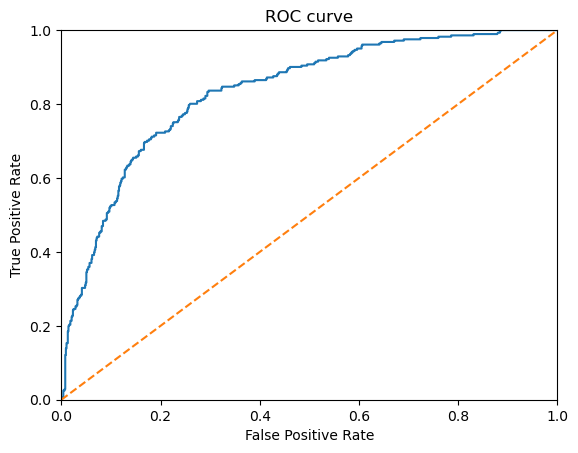

In [73]:
test_rf_model = RandomForestClassifier(n_estimators=100, max_depth=7,min_samples_split=12, random_state=12345)
test_rf_model.fit(features_test, target_test)

test_rf_probabilities = test_rf_model.predict_proba(features_valid)
test_rf_probabilities_one = test_rf_probabilities[:, 1]

test_rf_auc_roc = roc_auc_score(target_valid, test_rf_probabilities_one)

print(f"Auc-Roc (Test): {test_rf_auc_roc}")

predicted_valid = test_rf_model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
print(f"Accuracy (Test): {accuracy_valid}")

fpr, tpr, thresholds = roc_curve(target_valid, test_rf_probabilities_one)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Conclusion

Interconnect has tasked us with creating a machine learning model to predict which of their clients are going to churn services. We merged multiple dataframes to get the most accurate model for our prediction. 

**PreProcessing**
- We checked for duplicates
- We encoded our catorgorical data so that it could be used in the training of our model
- We merged our 4 dataframes into one for testing
- We dealt with missing data created with the merge by filling with "0" meaning the client does not have the service
- We scaled all of the data so no column is "heavier" than another

**Model Training** 
- We trained a Logistic Regression to give us a baseline model to refer back to
- We trained a LightGBM model with an Auc-Roc of 0.836 which was very similar to our RandomForest but slightly worse
- We trained and tuned a RandomForest Classifier an with our best parameters we got an Auc-Roc of 0.839, this was our best model so we used it in our test set and got and Auc_Roc of 0.834 and Accuracy of 0.798. This gives Interconnect a very good idea of which customers are going to churn in the future so they can push promotions and or discounts to these clients.

